In [17]:
import os
import glob
import numpy as np
import torch
import matplotlib.pyplot as plt

In [18]:
main_path = os.path.join('data', 'intel-mobileodt-cervical-cancer-screening')
data_path = os.path.join(main_path, 'train', 'train')
images  =  [glob.glob(os.path.join(data_path, d, "*.*")) for d in os.listdir(data_path)]
train_paths = np.hstack(images)
# Additional data
extra_1 = os.path.join(main_path, 'additional_Type_1_v2')
extra_2 = os.path.join(main_path, 'additional_Type_2_v2')
extra_3 = os.path.join(main_path, 'additional_Type_3_v2')
images1 = [glob.glob(os.path.join(extra_1, d, "*.*")) for d in os.listdir(extra_1)]
images2 = [glob.glob(os.path.join(extra_2, d, "*.*")) for d in os.listdir(extra_2)]
images3 = [glob.glob(os.path.join(extra_3, d, "*.*")) for d in os.listdir(extra_3)]
train_paths = np.append(train_paths, np.hstack(images1))
train_paths = np.append(train_paths, np.hstack(images2))
train_paths = np.append(train_paths, np.hstack(images3))

In [19]:
print(f'In this train set we have got a total of {len(train_paths)}')
N_EPOCHS = 10
OUTPUT_PATH = './'
BATCH_SIZE = 32
# detect and define device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
device = torch.device(device)
cpu = torch.device('cpu')

In this train set we have got a total of 8215
cuda


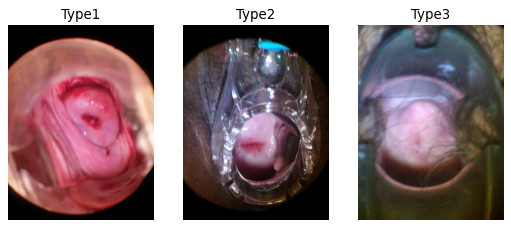

In [20]:
fig = plt.figure(figsize=(8, 8), dpi=80)
columns = 3
rows = 1
img_type1 = plt.imread(os.path.join(data_path, 'Type_1', '0.jpg'))
fig.add_subplot(rows, columns, 1)
plt.title("Type1")
plt.axis('off')
plt.imshow(img_type1)

img_type2 = plt.imread(os.path.join(data_path, 'Type_2', '1.jpg'))
fig.add_subplot(rows, columns, 2)
plt.title("Type2")
plt.axis('off')
plt.imshow(img_type2)

img_type3 = plt.imread(os.path.join(data_path, 'Type_3', '3.jpg'))
fig.add_subplot(rows, columns, 3)
plt.title("Type3")
plt.axis('off')
plt.imshow(img_type3)

In [21]:
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from PIL import Image

In [22]:
# Define your transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [23]:
# Custom dataset class
class CervicalCancerDataset(Dataset):
    def __init__(self, img_paths, transform=None):
        self.img_paths = img_paths
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except IOError:
            print(f"Could not read image: {img_path}. Possibly corrupted file.")
            return None, None
        label = int(os.path.basename(os.path.dirname(img_path)).split('_')[-1]) - 1

        if self.transform:
            image = self.transform(image)

        return image, label

In [24]:
def validate_image(image_path):
    try:
        Image.open(image_path).convert('RGB')
        return True
    except IOError:
        return False

train_paths = [path for path in train_paths if validate_image(path)]

In [25]:
# Create dataset
dataset = CervicalCancerDataset(train_paths, transform=transform)

In [26]:
# Create dataloader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [27]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [28]:
# Initialize the model
model = models.resnet50(pretrained=True)

In [29]:
# Adjust the final layer to match the number of classes in your dataset
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)  # Assuming there are 3 types of cervix

In [30]:
model = model.to(device)

In [31]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [16]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

# Training and adversarial attack
num_epochs = 10  # define the number of epochs you want
epsilon = 0.3  # Adjust as necessary
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    adversarial_corrects = 0

    for inputs, labels in dataloader:
        if inputs is None or labels is None:  # Skip corrupted files
            continue

        inputs = inputs.to(device).requires_grad_(True)  # Set requires_grad attribute to True for creating adversarial images
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()

        # Collect datagrad
        data_grad = inputs.grad.data

        # Call FGSM Attack
        adversarial_data = fgsm_attack(inputs, epsilon, data_grad)

        # Re-classify the perturbed image
        adversarial_outputs = model(adversarial_data)
        _, adversarial_preds = torch.max(adversarial_outputs, 1)

        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        adversarial_corrects += torch.sum(adversarial_preds == labels.data)

    epoch_loss = running_loss / len(dataset)
    epoch_acc = running_corrects.double() / len(dataset)
    adversarial_acc = adversarial_corrects.double() / len(dataset)

    print('Epoch {}/{} Loss: {:.4f} Acc: {:.4f} Adversarial Acc: {:.4f}'.format(epoch + 1, num_epochs, epoch_loss, epoch_acc, adversarial_acc))

print('Training complete')

Epoch 1/10 Loss: 0.9167 Acc: 0.5509 Adversarial Acc: 0.4632
Epoch 2/10 Loss: 0.7138 Acc: 0.6726 Adversarial Acc: 0.4390
Epoch 3/10 Loss: 0.4693 Acc: 0.8010 Adversarial Acc: 0.4256
Epoch 4/10 Loss: 0.2613 Acc: 0.9008 Adversarial Acc: 0.4463
Epoch 5/10 Loss: 0.1329 Acc: 0.9532 Adversarial Acc: 0.4741
Epoch 6/10 Loss: 0.1142 Acc: 0.9587 Adversarial Acc: 0.4833
Epoch 7/10 Loss: 0.1219 Acc: 0.9552 Adversarial Acc: 0.4873
Epoch 8/10 Loss: 0.0843 Acc: 0.9676 Adversarial Acc: 0.5019
Epoch 9/10 Loss: 0.0564 Acc: 0.9805 Adversarial Acc: 0.5109
Epoch 10/10 Loss: 0.0412 Acc: 0.9855 Adversarial Acc: 0.5266
Training complete


In [32]:
import torch
import torch.nn.functional as F

# Random Perturbation Attack
def random_perturbation_attack(image, epsilon):
    # Generate random perturbation
    perturbation = torch.FloatTensor(image.size()).uniform_(-epsilon, epsilon).to(image.device)
    # Add the perturbation to the image
    perturbed_image = image + perturbation
    # Clip the perturbed image to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

# Training and adversarial attack
num_epochs = 10  # define the number of epochs you want
epsilon = 0.3  # Adjust as necessary

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    adversarial_corrects = 0

    for inputs, labels in dataloader:
        if inputs is None or labels is None:  # Skip corrupted files
            continue

        inputs = inputs.to(device).requires_grad_(True)  # Set requires_grad attribute to True for creating adversarial images
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()

        # Collect datagrad
        data_grad = inputs.grad.data

        # Call Random Perturbation Attack
        adversarial_data = random_perturbation_attack(inputs, epsilon)

        # Re-classify the perturbed image
        adversarial_outputs = model(adversarial_data)
        _, adversarial_preds = torch.max(adversarial_outputs, 1)

        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        adversarial_corrects += torch.sum(adversarial_preds == labels.data)

    epoch_loss = running_loss / len(dataset)
    epoch_acc = running_corrects.double() / len(dataset)
    adversarial_acc = adversarial_corrects.double() / len(dataset)

    print('Epoch {}/{} Loss: {:.4f} Acc: {:.4f} Adversarial Acc: {:.4f}'.format(epoch + 1, num_epochs, epoch_loss, epoch_acc, adversarial_acc))

print('Training complete')

Epoch 1/10 Loss: 0.8974 Acc: 0.5613 Adversarial Acc: 0.5170
Epoch 2/10 Loss: 0.6753 Acc: 0.7029 Adversarial Acc: 0.5275
Epoch 3/10 Loss: 0.4109 Acc: 0.8297 Adversarial Acc: 0.5414
Epoch 4/10 Loss: 0.2078 Acc: 0.9247 Adversarial Acc: 0.5585
Epoch 5/10 Loss: 0.1378 Acc: 0.9512 Adversarial Acc: 0.5645
Epoch 6/10 Loss: 0.0946 Acc: 0.9672 Adversarial Acc: 0.5710
Epoch 7/10 Loss: 0.0661 Acc: 0.9770 Adversarial Acc: 0.5757
Epoch 8/10 Loss: 0.0580 Acc: 0.9812 Adversarial Acc: 0.5892
Epoch 9/10 Loss: 0.0533 Acc: 0.9833 Adversarial Acc: 0.5850
Epoch 10/10 Loss: 0.0373 Acc: 0.9882 Adversarial Acc: 0.5824
Training complete


In [16]:
import torch
import torch.nn.functional as F

# Gaussian Noise Attack
def gaussian_noise_attack(image, epsilon):
    # Generate Gaussian noise
    noise = torch.randn_like(image) * epsilon
    # Add the noise to the image
    perturbed_image = image + noise
    # Clip the perturbed image to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

# Training and adversarial attack
num_epochs = 10  # define the number of epochs you want
epsilon = 0.3  # Adjust as necessary

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    adversarial_corrects = 0

    for inputs, labels in dataloader:
        if inputs is None or labels is None:  # Skip corrupted files
            continue

        inputs = inputs.to(device).requires_grad_(True)  # Set requires_grad attribute to True for creating adversarial images
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()

        # Collect datagrad
        data_grad = inputs.grad.data

        # Call Gaussian Noise Attack
        adversarial_data = gaussian_noise_attack(inputs, epsilon)

        # Re-classify the perturbed image
        adversarial_outputs = model(adversarial_data)
        _, adversarial_preds = torch.max(adversarial_outputs, 1)

        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        adversarial_corrects += torch.sum(adversarial_preds == labels.data)

    epoch_loss = running_loss / len(dataset)
    epoch_acc = running_corrects.double() / len(dataset)
    adversarial_acc = adversarial_corrects.double() / len(dataset)

    print('Epoch {}/{} Loss: {:.4f} Acc: {:.4f} Adversarial Acc: {:.4f}'.format(epoch + 1, num_epochs, epoch_loss, epoch_acc, adversarial_acc))

print('Training complete')

Epoch 1/10 Loss: 0.9165 Acc: 0.5544 Adversarial Acc: 0.5167
Epoch 2/10 Loss: 0.6857 Acc: 0.6878 Adversarial Acc: 0.5293
Epoch 3/10 Loss: 0.4466 Acc: 0.8178 Adversarial Acc: 0.5261
Epoch 4/10 Loss: 0.2356 Acc: 0.9105 Adversarial Acc: 0.5414
Epoch 5/10 Loss: 0.1540 Acc: 0.9436 Adversarial Acc: 0.5467
Epoch 6/10 Loss: 0.1179 Acc: 0.9566 Adversarial Acc: 0.5718
Epoch 7/10 Loss: 0.1049 Acc: 0.9614 Adversarial Acc: 0.5699
Epoch 8/10 Loss: 0.0677 Acc: 0.9754 Adversarial Acc: 0.5723
Epoch 9/10 Loss: 0.0582 Acc: 0.9812 Adversarial Acc: 0.5837
Epoch 10/10 Loss: 0.0472 Acc: 0.9832 Adversarial Acc: 0.5969
Training complete


In [ ]:
# BIM attack code
def bim_attack(model, loss, images, labels, epsilon, alpha, num_iter):
    original_images = images.clone()
    for i in range(num_iter):
        images.requires_grad = True
        outputs = model(images)

        cost = loss(outputs, labels).to(device)
        cost.backward()

        attack_images = images + alpha*images.grad.sign()
        eta = torch.clamp(attack_images - original_images, min=-epsilon, max=epsilon)
        images = torch.clamp(original_images + eta, min=0, max=1).detach_()

    return images

# Training and adversarial attack
num_epochs = 10  # define the number of epochs you want
epsilon = 0.3  # Adjust as necessary
alpha = 0.01  # step size for BIM attack
num_iter = 10  # number of iterations for BIM attack
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    adversarial_corrects = 0

    for inputs, labels in dataloader:
        if inputs is None or labels is None:  # Skip corrupted files
            continue

        inputs = inputs.to(device).requires_grad_(True)  # Set requires_grad attribute to True for creating adversarial images
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()

        # Collect datagrad
        data_grad = inputs.grad.data

        # Call BIM Attack
        adversarial_data = bim_attack(model, criterion, inputs, labels, epsilon, alpha, num_iter)

        # Re-classify the perturbed image
        adversarial_outputs = model(adversarial_data)
        _, adversarial_preds = torch.max(adversarial_outputs, 1)

        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        adversarial_corrects += torch.sum(adversarial_preds == labels.data)

    epoch_loss = running_loss / len(dataset)
    epoch_acc = running_corrects.double() / len(dataset)
    adversarial_acc = adversarial_corrects.double() / len(dataset)

    print('Epoch {}/{} Loss: {:.4f} Acc: {:.4f} Adversarial Acc: {:.4f}'.format(epoch + 1, num_epochs, epoch_loss, epoch_acc, adversarial_acc))

print('Training complete')